# Проект e-commerce: вариант 1 
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

# РЕВЬЮ МОЕЙ РАБОТЫ

Наталья, привет!

Хорошо, что начала исследование с небольшого EDA

Видно, что ты понимаешь, какими методами в какой ситуации стоит пользоваться. Также не забываешь про комментирование, это очень важно при написании кода.

Хорошо, что определила в начале статус покупки.

1. **Баллы: 7/7**

Расчет верный.

2. **Баллы: 10/10**

Решение верное.

3. **Баллы: 4/7**  - ВНЕСЛА ПРАВКИ

Решение технически верное.

Балл снижен за работу с датой подтверждения оплаты (сторона продавца или процессинговой компании), а не временем оплаты (сторона покупателя). Подтверждение может пройти на следующий день и позже. Здесь мы анализируем покпательскую активность и нам интересно конечно как ведут себя покупатели.

- стоило учесть случаи когда значения для одного дня недели одинаковые.
4. **Баллы: 8/8**

Решение верное.

Повторно за работу с датой подтверждения оплаты не штрафую + для этого задания это не так критично.

Отмечу: первый и последний месяцы неполные. Стоило учесть это в расчетах или отбросить их.

5. **Баллы: 15/15**

Решение верное. Здорово, что применила тепловую карту для визуализации.

6. **Баллы: 23/23**

Хорошее решение.

Есть адаптация границ к фактическим распределениям, есть сегментация пользователей, есть выводы.

Желаю успешного завершения курса!

## **Итого: 67/70**

In [51]:
# Импортируем библиотеки  
import pandas as pd
import numpy as np
import seaborn as sns
import  matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from operator import attrgetter
from datetime import timedelta
import plotly.express as px


In [52]:
# Выгружаем файлы
customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-shishkova/Files.csv/olist_customers_dataset.csv')
order_items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-shishkova/Files.csv/olist_order_items_dataset.csv')
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-shishkova/Files.csv/olist_orders_dataset.csv')

In [53]:
# customers - таблица с уникальными идентификаторами пользователей

# customer_id — позаказный идентификатор пользователя
# customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
# customer_zip_code_prefix —  почтовый индекс пользователя
# customer_city —  город доставки пользователя
# customer_state —  штат доставки пользователя

customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [54]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [55]:
# order_items - товарные позиции, входящие в заказы

# order_id —  уникальный идентификатор заказа (номер чека)
# order_item_id —  идентификатор товара внутри одного заказа
# product_id —  ид товара (аналог штрихкода)
# seller_id — ид производителя товара
# shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
# price —  цена за единицу товара
# freight_value —  вес товара

order_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [56]:
order_items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [57]:
# Приведем даты в соответствующий формат
order_items['shipping_limit_date'] = order_items['shipping_limit_date'].apply(pd.to_datetime)
order_items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [58]:
# orders - таблица заказов 

# order_id —  уникальный идентификатор заказа (номер чека)
# customer_id —  позаказный идентификатор пользователя
# order_status —  статус заказа
# order_purchase_timestamp —  время создания заказа
# order_approved_at —  время подтверждения оплаты заказа
# order_delivered_carrier_date —  время передачи заказа в логистическую службу
# order_delivered_customer_date —  время доставки заказа
# order_estimated_delivery_date —  обещанная дата доставки

orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [59]:
 orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [60]:
# Приведем даты в соответствующий формат
orders[['order_purchase_timestamp', 'order_approved_at', 
       'order_delivered_carrier_date', 
       'order_delivered_customer_date', 
       'order_estimated_delivery_date']] = orders[['order_purchase_timestamp', 'order_approved_at', 
                                                 'order_delivered_carrier_date', 'order_delivered_customer_date', 
                                                 'order_estimated_delivery_date']].apply(pd.to_datetime)
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [61]:
# Пример структуры данных 
orders.query('order_id == "00143d0f86d6fbd9f9b38ab440ac16f5"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
36265,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06


In [62]:
# Проверим кол-во строк в таблицах

In [63]:
customers.shape

(99441, 5)

In [64]:
order_items.shape

(112650, 7)

In [65]:
orders.shape

(99441, 8)

In [66]:
# Проверим таблицы на пропущенные значения

In [67]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [68]:
order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [69]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

По таблице заказов видим логичные пропущенные значения, те не все заказы завершены

order_approved_at —  время подтверждения оплаты заказа
order_delivered_carrier_date —  время передачи заказа в логистическую службу
order_delivered_customer_date —  время доставки заказа

In [70]:
# Посмотрим кол-во уникальных заказов по статусам 

# created —  создан
# approved —  подтверждён
# invoiced —  выставлен счёт
# processing —  в процессе сборки заказа
# shipped —  отгружен со склада
# delivered —  доставлен пользователю
# unavailable —  недоступен
# canceled —  отменён

In [71]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13


In [72]:
orders.groupby('order_status', as_index=False).agg({'order_id': 'count'})

,order_status,order_id
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [73]:
# Сохраним в датафрейм заказы доставленные пользователю, в процессе сборки и отгруженные со склада
df = orders.query('order_status == "delivered" or order_status == "processing" or order_status == "shipped"')
df.shape[0]

97886

In [74]:
df.isna().sum()
# order_approved_at —  время подтверждения оплаты заказа
# order_delivered_carrier_date —  время передачи заказа в логистическую службу
# order_delivered_customer_date —  время доставки заказа

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  14
order_delivered_carrier_date      303
order_delivered_customer_date    1416
order_estimated_delivery_date       0
dtype: int64

Всего 97886 заказа, имеющие статус доставленные пользователю, в процессе сборки и отгруженные со склада.

Из них 1733 заказа с пропущенными данными: 14 заказов о подтверждении оплаты, 303 заказа о времени передачи в логистическую службу и 1416 заказов о времени доставки. 

Из этого можно сделать вывод, что всего лишь 1,77% из всех заказов имеют пропущенные данные, что говорит о большой конверсии пользователями.

# 1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

In [75]:
# Объединим таблицу с уникальными пользователями с таблицей заказов по 'customer_id',
# число строк у таблиц одинаковое
customers_orders = customers.merge(orders, on = 'customer_id', how = 'inner')
customers_orders.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06


In [76]:
# Сгруппируем по уникальным пользователям и посчитаем пользователей, 
# которые совершили покупку только один раз
customers_orders \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_id': 'count'}) \
    .query('order_id == 1') \
    .count()

customer_unique_id    93099
order_id              93099
dtype: int64

In [77]:
# Отфильтруем таблицу по статусам "delivered", "processing", "shipped"
# и посчитаем пользователей, которые совершили покупку только один раз

customers_orders \
    .query('order_status in ["delivered", "processing", "shipped"]') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_id': 'count'}) \
    .query('order_id == 1') \
    .count()

customer_unique_id    91814
order_id              91814
dtype: int64

Ответ: 91 814 пользователей, которые совершили покупку только один раз 

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (10 баллов)

In [78]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13


In [79]:
# приведем дату создания заказа в нужный нам формат, тк нам нужно определить среднее в месяц
orders['date_purchase_timestamp'] = orders.order_purchase_timestamp.dt.strftime('%Y-%m')

In [80]:
# посмотрим кол-во заказов без статуса "delivered"
orders.query('order_status != "delivered"').shape[0]

2963

In [82]:
# выведем в таблицу по этим статусам и найдем интересующие нас причины недоставленных заказов по месяцам
no_delivered = orders.query('order_status != "delivered"') \
    .groupby(['date_purchase_timestamp', 'order_status'], as_index=False) \
    .agg({'order_id': 'count'})
no_delivered

,date_purchase_timestamp,order_status,order_id
0,2016-09,canceled,2
1,2016-09,shipped,1
2,2016-10,canceled,24
3,2016-10,invoiced,18
4,2016-10,processing,2
...,...,...,...
108,2018-08,shipped,47
109,2018-08,unavailable,7
110,2018-09,canceled,15
111,2018-09,shipped,1


In [83]:
# для наглядности выведем визуализацию причин недоставленных заказов в виде круговой диаграммы 
df = no_delivered
fig = px.pie(df, values='order_id', names='order_status')
fig.show()

In [84]:
# В нашем случае нас интересуют 2 статуса:
# unavailable / недоступен - 609 заказов
# canceled / отменён - 625 заказов

# Остальные статусы говорят о процессе оформления/оплаты/сборки и могут/должны быть доставлены

In [85]:
# посчитаем среднее по интересующим нас причинам
mean_no_delivered = no_delivered \
    .query('order_status in ["unavailable", "canceled"]') \
    .groupby('order_status', as_index=False) \
    .agg({'order_id': 'mean'}) \
    .rename(columns={'order_id': 'mean_order'}) \
    .round()
mean_no_delivered

,order_status,mean_order
0,canceled,26.0
1,unavailable,29.0


Ответ: в среднем по причине отмены не доставляется 26 заказов, 
в среднем по причине недоступности товара не доставляется 29 заказов.

# 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (7 баллов)

1. **Баллы: 4/7**

Решение технически верное.

Балл снижен за работу с датой подтверждения оплаты (сторона продавца или процессинговой компании), а не временем оплаты (сторона покупателя). Подтверждение может пройти на следующий день и позже. Здесь мы анализируем покпательскую активность и нам интересно конечно как ведут себя покупатели.

- стоило учесть случаи когда значения для одного дня недели одинаковые.

In [86]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,date_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07


In [87]:
order_items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [88]:
# объединяем таблицу заказов с таблицей товарных позиций
orders_items_merge = orders.merge(order_items, on = 'order_id')
orders_items_merge.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,date_purchase_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76


# внесла правку по ревью

время подтверждения оплаты заказа/order_approved_at 

заменила на order_purchase_timestamp —  время создания заказа

In [89]:
# создаем новую колонку день недели и 
# время подтверждения оплаты заказа/order_approved_at приводим в формат дня недели 
# orders_items_merge['weekday'] = orders_items_merge.order_approved_at.dt.day_name()

# создаем новую колонку день недели и 
# order_purchase_timestamp —  время создания заказа приводим в формат дня недели 
orders_items_merge['weekday'] = orders_items_merge.order_purchase_timestamp.dt.day_name()

In [90]:
orders_items_merge.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,date_purchase_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,weekday
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday


In [96]:
# группируем по ид товара и дню недели и считаем кол-во заказов, 
# выполняем сортировку от большего к меньшему, удаляем дубликаты ид товара 
# и выводим таблицу по каждому товару

weekday_count = orders_items_merge \
    .groupby(['product_id', 'weekday'], as_index=False) \
    .agg({'customer_id': 'count'}) \
    .sort_values('customer_id', ascending=False) \
    .drop_duplicates('product_id') 
weekday_count

,product_id,weekday,customer_id
15902,422879e10f46682990de24d770e7f83d,Wednesday,93
36513,99a4788cb24856965c36a24e339b6058,Monday,92
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
20127,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
13537,389d119b48cf3043d311335e499d9c6b,Thursday,67
...,...,...,...
24030,6432d844f2be41bb6f2fd279e23415da,Friday,1
24009,6421ae053bb80dff3ceae1f217f54ed4,Monday,1
24010,642247ccf62585635cefa1bf09f59b94,Sunday,1
24022,642e125cbc752b4eeb8faf442319c39f,Thursday,1


In [101]:
# посмотрим кол-во оплаченных заказов по дням недели 
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

week_day_count = weekday_count \
    .groupby('weekday', as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'order_count'}) \
    .set_index('weekday') \
    .reindex(week) \
    .reset_index()
week_day_count

,weekday,order_count
0,Monday,5780
1,Tuesday,4994
2,Wednesday,4888
3,Thursday,4638
4,Friday,5262
5,Saturday,3564
6,Sunday,3825


In [102]:
# визуализируем полученные данные через бар-чарт
fig = px.bar(week_day_count, x = 'weekday', y = 'order_count')
fig.show()

Видим относительно дней недели, что чаще всего пользователи оплачивают товары в понедельник, 
в субботу реже всего.

# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?  Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

In [103]:
customers_orders.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06


In [104]:
order_items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [105]:
# объединяем таблицы 
customers_orders_items = customers_orders.merge(order_items, on='order_id')
customers_orders_items.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48


In [106]:
# создаем новую колонку на основе даты подтверждения оплаты заказа и приводим ее в формат месяц/год
customers_orders_items['approved_month'] = customers_orders_items.order_purchase_timestamp.dt.strftime('%Y-%m')
customers_orders_items.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,approved_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,2018-01


In [108]:
# создаем новую колонку с количеством недель в соответствующем месяце
customers_orders_items['week_count'] = customers_orders_items.order_purchase_timestamp.dt.days_in_month / 7
customers_orders_items.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,approved_month,week_count
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,2017-05,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,2018-01,4.428571


In [109]:
# считаем кол-во заказов в месяц по уникальным пользователям, снова группируем и суммируем данные 
approved_week_count = customers_orders_items \
    .groupby(['customer_unique_id', 'approved_month', 'week_count'], as_index=False) \
    .agg({'customer_id': 'count'}) \
    .groupby(['customer_unique_id', 'approved_month', 'week_count'], as_index = False) \
    .agg({'customer_id' : 'sum'}) \
    .rename(columns = {'customer_id':'sum_order_count'})

In [112]:
# выводим среднее кол-во заказов в неделю за каждый месяц и сортируем по  убыванию
approved_week_count['mean_orders_count'] = approved_week_count.sum_order_count / approved_week_count.week_count
approved_week_count.sort_values('mean_orders_count', ascending = False)

,customer_unique_id,approved_month,week_count,sum_order_count,mean_orders_count
76234,c8460e4251689ba205045f3ea17884a1,2018-08,4.428571,24,5.419355
74614,c402f431464c72e27330a67f7b94d4fb,2018-02,4.000000,20,5.000000
26387,4546caea018ad8c692964e3382debd19,2017-07,4.428571,21,4.741935
40214,698e1cf81d01a3d389d96145f7fa6df8,2017-08,4.428571,20,4.516129
5860,0f5ac8d5c31de21d2f25e24be15bbffb,2017-11,4.285714,18,4.200000
...,...,...,...,...,...
42127,6e8ea825d9f2edbf2a6e5531fc09d702,2017-07,4.428571,1,0.225806
42128,6e8f22264f42c5c1993803e739260ecf,2017-12,4.428571,1,0.225806
42129,6e8f75c008bbe43bb1c464d691c47db4,2018-03,4.428571,1,0.225806
42131,6e8fcf6171e78dd27e96456713c17f31,2017-05,4.428571,1,0.225806


# 5.1. Выполните когортный анализ пользователей. 

5.2. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут. Для визуализации когортной таблицы рекомендуем использовать пример из 8-го урока python, раздел “Стильный урок”, степ 5. (15 баллов)

In [113]:
# для когортного анализа возьмем объединенную таблицу заказов и таблицу пользователей
customers_orders.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06


In [114]:
# на основе колонки подтверждения заказа создаем колонку month и приводим к соответствующему формату
customers_orders['month'] = customers_orders.order_purchase_timestamp.dt.to_period('M')
customers_orders.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01


In [115]:
# посмотрим на периоды и видим, что у нас 2017 полный год с января по декабрь
customers_orders.month.sort_values().unique()

<PeriodArray>
['2016-09', '2016-10', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04',
 '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11',
 '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
 '2018-07', '2018-08', '2018-09', '2018-10']
Length: 25, dtype: period[M]

In [116]:
# создадим датафрейм за 2017 год
customers_orders_2017 = customers_orders.query('"2017-01" <= month <= "2017-12"')
customers_orders_2017.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,2017-09


In [117]:
# группируем по уникальному пользователю и создаем колонку с датой первой покупки
first_order = customers_orders_2017 \
    .groupby(['customer_unique_id'], as_index=False) \
    .agg({'month': 'first'}) \
    .rename(columns={'month': 'first_order'})
first_order.head(4)

,customer_unique_id,first_order
0,0000f46a3911fa3c0805444483337064,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11
3,0005e1862207bf6ccc02e4228effd9a0,2017-03


In [118]:
# объединяем датафреймы
customers_orders_2017_retention = customers_orders_2017.merge(first_order, how = 'inner', on='customer_unique_id')
customers_orders_2017_retention.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,first_order
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,2017-05
1,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,2017-09,2017-09


In [119]:
# фильтруем по статусу и считаем кол-во уникальных пользователей за период
customers_orders_2017_retention = customers_orders_2017_retention \
    .query('order_status in ["delivered", "processing", "shipped"]') \
    .groupby(['first_order', 'month'], as_index=False) \
    .agg({'customer_unique_id': 'nunique'}) \
    .rename(columns={'customer_unique_id': 'customer_total'})

customers_orders_2017_retention

,first_order,month,customer_total
0,2017-01,2017-01,733
1,2017-01,2017-02,1
2,2017-01,2017-04,1
3,2017-01,2017-06,1
4,2017-01,2017-07,3
...,...,...,...
127,2017-12,2017-08,6
128,2017-12,2017-09,7
129,2017-12,2017-10,4
130,2017-12,2017-11,24


In [120]:
# проверяем совпадение периода
customers_orders_2017_retention.first_order.unique()

<PeriodArray>
['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07',
 '2017-08', '2017-09', '2017-10', '2017-11', '2017-12']
Length: 12, dtype: period[M]

In [121]:
# проверяем совпадение периода
customers_orders_2017_retention.month.unique()

<PeriodArray>
['2017-01', '2017-02', '2017-04', '2017-06', '2017-07', '2017-09', '2017-11',
 '2017-12', '2017-03', '2017-05', '2017-10', '2017-08']
Length: 12, dtype: period[M]

In [122]:
customers_orders_2017_retention = customers_orders_2017_retention.query('month >= first_order')

In [123]:
# рассчитываем когортный период
customers_orders_2017_retention['cohort_period'] = customers_orders_2017_retention.month - customers_orders_2017_retention.first_order

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [124]:
customers_orders_2017_retention

,first_order,month,customer_total,cohort_period
0,2017-01,2017-01,733,<0 * MonthEnds>
1,2017-01,2017-02,1,<MonthEnd>
2,2017-01,2017-04,1,<3 * MonthEnds>
3,2017-01,2017-06,1,<5 * MonthEnds>
4,2017-01,2017-07,3,<6 * MonthEnds>
...,...,...,...,...
108,2017-10,2017-11,17,<MonthEnd>
109,2017-10,2017-12,8,<2 * MonthEnds>
120,2017-11,2017-11,7196,<0 * MonthEnds>
121,2017-11,2017-12,16,<MonthEnd>


In [125]:
# убираем ненужный атрибут
customers_orders_2017_retention['cohort_period'] = customers_orders_2017_retention['cohort_period'].apply(attrgetter("n"))
customers_orders_2017_retention

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,first_order,month,customer_total,cohort_period
0,2017-01,2017-01,733,0
1,2017-01,2017-02,1,1
2,2017-01,2017-04,1,3
3,2017-01,2017-06,1,5
4,2017-01,2017-07,3,6
...,...,...,...,...
108,2017-10,2017-11,17,1
109,2017-10,2017-12,8,2
120,2017-11,2017-11,7196,0
121,2017-11,2017-12,16,1


In [126]:
# создаем итоговую таблицу с полученными данными
cohort_df = customers_orders_2017_retention.pivot(index='first_order', columns='cohort_period', 
                                           values='customer_total')
cohort_df

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11
first_order,,,,,,,,,,,,
2017-01,733.0,1.0,NaN,1.0,NaN,1.0,3.0,NaN,1.0,NaN,1.0,1.0
2017-02,1661.0,1.0,2.0,1.0,5.0,1.0,NaN,1.0,2.0,1.0,1.0,NaN
2017-03,2542.0,8.0,7.0,5.0,1.0,2.0,2.0,4.0,4.0,2.0,NaN,NaN
2017-04,2293.0,9.0,1.0,2.0,6.0,2.0,5.0,4.0,3.0,NaN,NaN,NaN
2017-05,3493.0,11.0,8.0,3.0,6.0,7.0,6.0,2.0,NaN,NaN,NaN,NaN
2017-06,3081.0,6.0,4.0,8.0,3.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2017-07,3814.0,12.0,7.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4112.0,14.0,10.0,6.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4061.0,16.0,8.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
# посчитаем Retention Rate 
# изменим данные, так, чтобы показать доли возврата от первоначального размера когорты.
first = cohort_df[0]

retention_rate = cohort_df.divide(first, axis = 0)
retention_rate

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11
first_order,,,,,,,,,,,,
2017-01,1.0,0.001364,NaN,0.001364,NaN,0.001364,0.004093,NaN,0.001364,NaN,0.001364,0.001364
2017-02,1.0,0.000602,0.001204,0.000602,0.003010,0.000602,NaN,0.000602,0.001204,0.000602,0.000602,NaN
2017-03,1.0,0.003147,0.002754,0.001967,0.000393,0.000787,0.000787,0.001574,0.001574,0.000787,NaN,NaN
2017-04,1.0,0.003925,0.000436,0.000872,0.002617,0.000872,0.002181,0.001744,0.001308,NaN,NaN,NaN
2017-05,1.0,0.003149,0.002290,0.000859,0.001718,0.002004,0.001718,0.000573,NaN,NaN,NaN,NaN
2017-06,1.0,0.001947,0.001298,0.002597,0.000974,0.002272,0.002272,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.003146,0.001835,0.001311,0.001311,0.001311,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.003405,0.002432,0.001459,0.002189,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.003940,0.001970,0.000985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
# когорта с самым высоким retention на 3-й месяц
retention_rate[retention_rate[3] == retention_rate[3].max()].index

PeriodIndex(['2017-06'], dtype='period[M]', name='first_order')

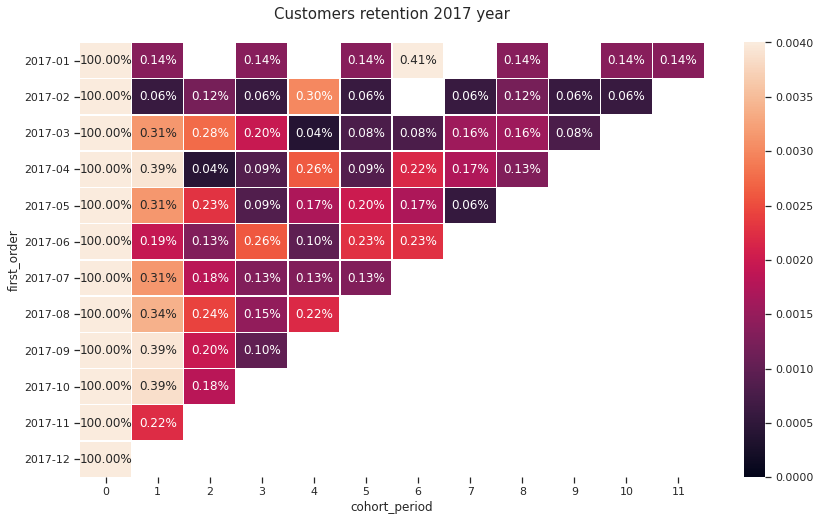

In [129]:
# визуализируем полученные данные при помощи тепловой карты
sns.set(style='ticks',
        rc={"figure.figsize": (14, 8)})
plt.title('Customers retention 2017 year\n', fontsize = 15)
sns.heatmap(retention_rate, annot=True, vmin = 0.0, vmax = 0.004, fmt='.2%', linewidth=0.3)

Ответ: Наиболее высокий Retention за третий месяц у когорты пользователей, которые совершили 
заказ '2017-06' - он составляет 0,26%.
В разрезе общего когортного анализа видим, что в первый месяц Retention максимален

# 6. построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. (23 балла)

 В кластеризации можешь выбрать следующие метрики: 
 
 - R - время от последней покупки пользователя до текущей даты
 - F - суммарное количество покупок у пользователя за всё время
 - M - сумма покупок за всё время
 
Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. 

In [130]:
# для постороения RFM-сегментации будем работать с общим файлом (объединенные 3 таблицы)
customers_orders_items.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,approved_month,week_count
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,2017-05,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,2018-01,4.428571


In [131]:
# проверяем на пропуски данных
customers_orders_items.isna().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
approved_month                      0
week_count                          0
dtype: int64

In [132]:
# удаляем все пропущенные данные
customers_orders_items = customers_orders_items.dropna()

In [133]:
# определяем необходимый статус для расчетов 
RFM_customers_orders_items = customers_orders_items.query('order_status in ["delivered", "processing", "shipped"]') 

In [134]:
# определяем максимальный/последний день подтверждени оплаты заказа
last_day = RFM_customers_orders_items.order_purchase_timestamp.max()
last_day

Timestamp('2018-08-29 15:00:37')

In [135]:
# установим NOW дату на один день после последней покупки
now = last_day + timedelta(days = 1)
now

Timestamp('2018-08-30 15:00:37')

In [136]:
# рассчитаем следующие метрики:
# R - время от последней покупки пользователя до текущей даты
# F - суммарное количество покупок у пользователя за всё время
# M - сумма покупок за всё время

rfm = RFM_customers_orders_items \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_purchase_timestamp': lambda x: (now - x.max()).days, 'order_id': 'count', 'price': 'sum'}) \
    .rename(columns={'order_purchase_timestamp': 'R', 'order_id': 'F', 'price': 'M'})
rfm .head()    

,customer_unique_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00


In [137]:
# посмотрим на данные с помощью метода квантилей для каждого параметра
quintiles = rfm[['R', 'F', 'M']].quantile([0.1, 0.4, 0.7, 0.9])
quintiles

,R,F,M
0.1,42.0,1.0,25.98
0.4,177.0,1.0,69.90
0.7,312.0,1.0,139.00
0.9,466.0,2.0,279.99


In [138]:
# большая часть покупателей делают 1 заказ
rfm.F.value_counts()

1     81728
2      8795
3      1646
4       621
5       241
6       190
7        45
8        16
10       11
11       11
9        10
12        9
15        3
14        3
20        2
13        2
18        1
21        1
24        1
Name: F, dtype: int64

In [139]:
# посмотрим на данные показателей
rfm.describe()

,R,F,M
count,93336.000000,93336.000000,93336.000000
mean,237.903853,1.180391,141.621663
std,152.552964,0.620913,215.714143
min,1.000000,1.000000,0.850000
25%,114.000000,1.000000,47.650000
50%,219.000000,1.000000,89.700000
75%,346.000000,1.000000,154.692500
max,714.000000,24.000000,13440.000000


In [140]:
# определим случайные показатели для  метрик, основываясь на таблицу квантилей и общие по параметрам
rfm['R_seg'] = pd.cut(rfm.R, bins=[0, 31, 186, 715],
                      labels=['3', '2', '1'])

rfm['F_seg'] = pd.cut(rfm.F, bins=[0, 1, 3, 25],
                      labels=['1', '2', '3'])

rfm['M_seg'] = pd.cut(rfm.M, bins=[0, 70, 200, 13500],
                      labels=['1', '2', '3',])
rfm.head(3)

,customer_unique_id,R,F,M,R_seg,F_seg,M_seg
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.9,2,1,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.9,2,1,1
2,0000f46a3911fa3c0805444483337064,537,1,69.0,1,1,1


In [141]:
# адаптируем показатели в строковый метод
rfm['R_seg'] = rfm['R_seg'].astype(str)
rfm['F_seg'] = rfm['F_seg'].astype(str)
rfm['M_seg'] = rfm['M_seg'].astype(str)

# соединяем показатели в столбец RFM
rfm['RFM']  = rfm.R_seg + rfm.F_seg + rfm.M_seg
rfm.head(3)

,customer_unique_id,R,F,M,R_seg,F_seg,M_seg,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.9,2,1,2,212
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.9,2,1,1,211
2,0000f46a3911fa3c0805444483337064,537,1,69.0,1,1,1,111


Опишем получившиеся метрики

- R - время от последней покупки пользователя до текущей даты (чем выше метрика, тем меньше срок)

3 - от 0 до 31 дней

2 - от 1 до 6 месяцев

1 - от 6 месяцев и более

- F - суммарное количество покупок у пользователя за всё время (чем выше метрика, тем больше заказов)

1 - 1 заказ

2 - 2-3 заказа

3 - 4 и более заказов

- M - сумма покупок за всё время (чем выше метрика, тем больше сумма)

1  - 0-70 евро

2 - 70-200 евро

3 - 200 и более евро

In [142]:
# определим описание каждому сегменту
segt_map = {
    r'1[1-2]': 'спящие',
    r'2[1]': 'рискованные',
    r'[1]3': 'не могу потерять',
    r'3[1-2]': 'новые клиенты',
    r'[2][2-3]': 'потенциальные',
    r'3[3]': 'чемпионы'
}

rfm['Segment'] = rfm['R_seg'].map(str) + rfm['F_seg'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,customer_unique_id,R,F,M,R_seg,F_seg,M_seg,RFM,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,2,1,2,212,рискованные
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,2,1,1,211,рискованные
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,1,111,спящие
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1,111,спящие
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,1,1,2,112,спящие


In [143]:
# посчитаем кол-во пользователей по описанию сегмента
rfm_segment = rfm \
    .groupby('Segment', as_index=False)  \
    .agg({'customer_unique_id': 'count'}) \
    .rename(columns={'customer_unique_id': 'Segment_count'}) \
    .sort_values('Segment_count', ascending=False)
rfm_segment

,Segment,Segment_count
4,спящие,53062
3,рискованные,28444
1,новые клиенты,6920
2,потенциальные,4201
0,не могу потерять,627
5,чемпионы,82


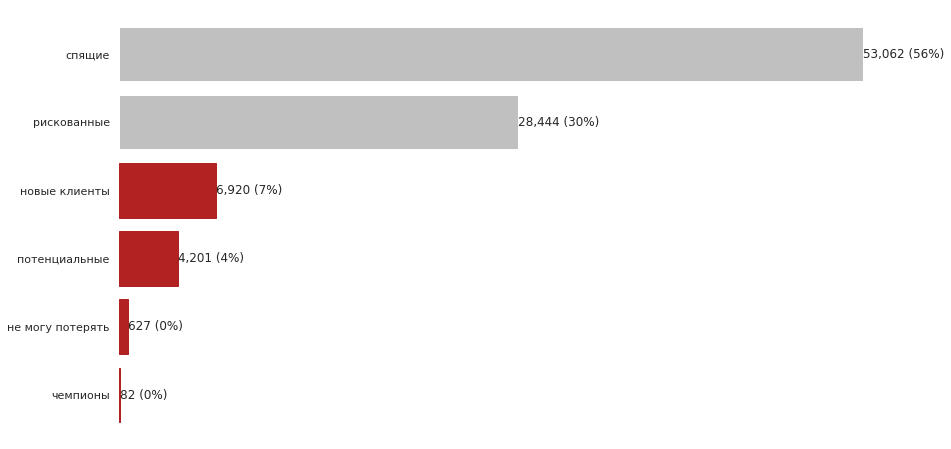

In [144]:
# подсчитаем количество клиентов в каждом сегменте и визуализируем 
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['чемпионы', 'не могу потерять', 'потенциальные', 'новые клиенты']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )
sns.set(rc={"figure.figsize": (8, 6)})
plt.show()

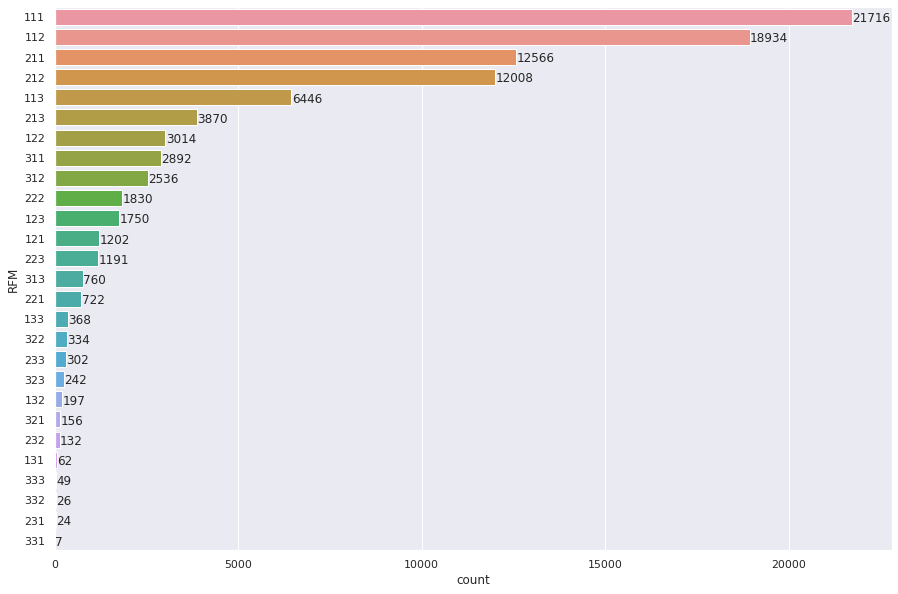

In [145]:
# визуализируем наши данные получившейся сегментации покупателей
sns.set(rc={"figure.figsize": (15, 10)})
ax = sns.countplot(y=rfm.RFM, order=rfm.RFM.value_counts().index)
for p in ax.patches:
        ax.annotate(p.get_width(),
                    (p.get_width() + 10, p.get_y() + p.get_height()*0.8))

Ответ

"Спящие" пользователи 111 (сумма до 70 евро) и 112 (сумма до 200 евро) покупали более полугода назад и произвели всего лишь одну покупку. Этих клиентов максимальное количество, но потенциальными клиентами они не являются.

"Рискованные" - это те клиенты, которые в течении полугода сделали 1 заказ и не являются новыми.

"Чемпионы" 333 покупают на сумму от 200 евро и более, имеют от 4 и более заказов и покупки были в течении месяца.
Эти постоянные платежеспособные клиенты, нужно проявлять к ним максимальную лояльность, чтобы не потерять.

"Новые клиенты" 311, 312, 313, 321, 322, 323 - это новые покупатели, которые произвели разное кол-во покупок и на разные суммы в течение месяца, с ними нужно работать над их возвращаемостью.

"Потенциальные" и "не могу потерять"  - это клиенты, которые производят сразу несколько покупок. Такие клиенты интересны бизнесу, с ними нужно поработать над их возвращаемостью.

Вывод: необходимо работать над возвратом клиента, разработать программу лояльности, акции для клиентов и мотивационные программы для отдела продаж и логистики.
